In [1]:
cd

/home/luxx0489


In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import mne

from scipy.signal import welch,periodogram
from scipy.io import loadmat, savemat

#%matplotlib qt

In [1]:
ID_list = [6,7,8,9,10,12,13,14,16,17,18,19,20,21,22]
Freq_list = [43.43, 98.28,34.28, 91.42]

output = np.empty((len(ID_list)*2*len(Freq_list),71))
# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98), PLV*66 (64 channels+mastoid)

row_num = 0

for iSubject in [8]:#ID_list:# range(2,18):

    folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/"
    sub_id = 'Sub' + str(iSubject) + '_LF'
    raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                   stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
    events = mne.find_events(raw)

    epochs = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
    epochs.load_data()
    ep_m = epochs.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])
    ep_a = epochs.copy().set_eeg_reference(ref_channels='average')

    data = ep_a.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_a = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_a = abs((xw_a/abs(xw_a)).mean(0))
    
    data = ep_m.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]   
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_m = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_m = abs((xw_m/abs(xw_m)).mean(0))
    
    freq = np.fft.rfftfreq(data.shape[2],1/4096)
    
    for iFreq in range(len(Freq_list)):
        index = np.argmin(abs(freq-Freq_list[iFreq]))

        output[row_num,0] = iSubject
        output[row_num,1] = 0
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_a[0:66,index]
        output[row_num,69:71] = plv_a[67:69,index]
        
        row_num +=1
        
        output[row_num,0] = iSubject
        output[row_num,1] = 1
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_m[0:66,index]
        output[row_num,69:71] = plv_m[67:69,index]

        row_num +=1

NameError: name 'np' is not defined

In [20]:

out = xw_m[:,0:64,:]
sample_dat = np.concatenate((np.real(out),np.imag(out)),axis=1)

sample_dat.shape

(1000, 128, 897)

In [68]:

out = xw_a[:,0:64,:]
sample_dat = np.concatenate((np.real(out),np.imag(out)),axis=1)


T2 = np.zeros(sample_dat.shape[2])

for iFreq in range(5,sample_dat.shape[2]-3):
    batch = sample_dat[:,:,iFreq].transpose(1,0)
    S_inv = np.linalg.inv(np.cov(batch))
    T2[iFreq]=batch.mean(1) @S_inv @batch.mean(1)


(20, 150)

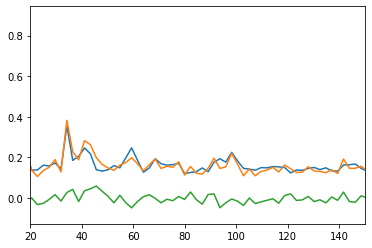

In [70]:
plt.plot(freq,T2)
plt.plot(freq,plv_a[0:64,:].mean(0)*5)
plt.plot(freq,plv_a[0:64,:].mean(0)*5 - T2)

plt.xlim((20,150))

(20, 150)

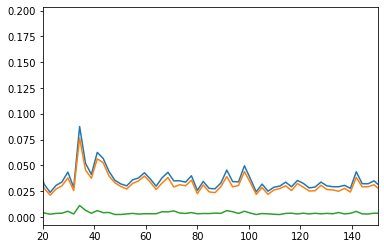

In [72]:
plt.plot(freq,np.sqrt((plv_a[0:64,:]**2).mean(0)))
plt.plot(freq,plv_a[0:64,:].mean(0))
plt.plot(freq,np.sqrt((plv_a[0:64,:]**2).mean(0))-plv_a[0:64,:].mean(0))

plt.xlim((20,150))

                                 ID        A1        A2        A3        A4  \
reference      frequency                                                      
average        34.28      14.133333  0.066497  0.059232  0.087284  0.108894   
               43.43      14.133333  0.029625  0.026436  0.048100  0.065564   
               91.42      14.133333  0.043018  0.034836  0.063650  0.087157   
               98.28      14.133333  0.031367  0.028463  0.050066  0.082447   
linked mastoid 34.28      14.133333  0.086449  0.072768  0.102245  0.112737   
               43.43      14.133333  0.039040  0.036411  0.058387  0.062850   
               91.42      14.133333  0.090183  0.076427  0.120659  0.139910   
               98.28      14.133333  0.056976  0.053358  0.084486  0.097750   

                                A5        A6        A7        A8        A9  \
reference      frequency                                                     
average        34.28      0.093098  0.066813  0.05398

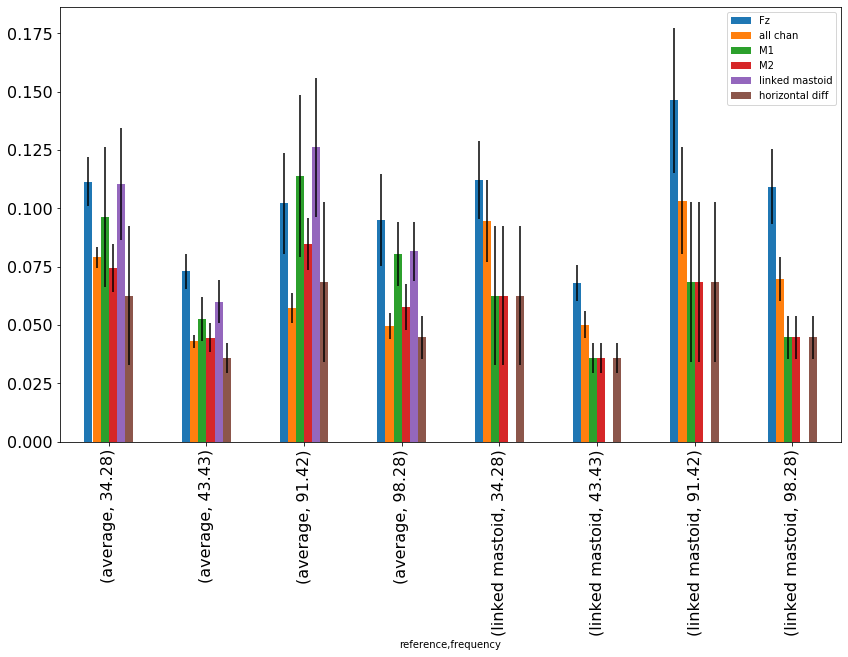

In [88]:
df = pd.DataFrame(output,columns=['ID','reference','frequency']
                  + epochs.info['ch_names'][0:66] + ['linked mastoid','horizontal diff'])
df.head()

dictionary = {0:'average',1:'linked mastoid'}

df_f = df.copy().replace({'reference':dictionary})

df_f['all chan'] = df_f.loc[:,'A1':'B32'].mean(axis=1)
df_f['Fz'] = df_f['B6']
df_f['M1'] = df_f['EXG1']
df_f['M2'] = df_f['EXG2']
df_group = df_f.groupby(by=['reference','frequency'])
df_avg = df_group.mean()
df_std = df_group.std()/np.sqrt(len(ID_list))
df_avg.drop(columns='ID')
print(df_avg)

p = df_avg[['Fz','all chan','M1','M2','linked mastoid','horizontal diff']].plot(kind='bar',yerr=df_std,figsize = (14,8),fontsize=16)


In [17]:
df_group[['Fz','all chan','linked mastoid','horizontal diff']].corr(method='spearman')

Fz  all chan  linked mastoid  \
reference      frequency                                                       
average        34.28     Fz               1.000000  0.657143        0.271429   
                         all chan         0.657143  1.000000        0.050000   
                         linked mastoid   0.271429  0.050000        1.000000   
                         horizontal diff  0.292857  0.042857       -0.035714   
               43.43     Fz               1.000000  0.807143        0.271429   
                         all chan         0.807143  1.000000        0.296429   
                         linked mastoid   0.271429  0.296429        1.000000   
                         horizontal diff -0.078571 -0.160714       -0.071429   
               91.42     Fz               1.000000  0.592857        0.200000   
                         all chan         0.592857  1.000000        0.632143   
                         linked mastoid   0.200000  0.632143        1.000000   
                         horizontal diff -0.032143 -0.182143        0.071429   
               98.28     Fz               1.000000  0.867857        0.278571   
                         all chan         0.867857  1.000000        0.110714   
                         linked mastoid   0.278571  0.110714        1.000000   
                         horizontal diff -0.271429 -0.546429       -0.164286   
linked mastoid 34.28     Fz               1.000000  0.732143             NaN   
                         all chan         0.732143  1.000000             NaN   
                         linked mastoid        NaN       NaN             NaN   
                         horizontal diff -0.021429 -0.142857             NaN   
               43.43     Fz               1.000000  0.632143             NaN   
                         all chan         0.632143  1.000000             NaN   
                         linked mastoid        NaN       NaN             NaN   
                         horizontal diff -0.317857 -0.053571             NaN   
               91.42     Fz               1.000000  0.778571             NaN   
                         all chan         0.778571  1.000000             NaN   
                         linked mastoid        NaN       NaN             NaN   
                         horizontal diff  0.342857  0.142857             NaN   
               98.28     Fz               1.000000  0.935714             NaN   
                         all chan         0.935714  1.000000             NaN   
                         linked mastoid        NaN       NaN             NaN   
                         horizontal diff -0.125000 -0.167857             NaN   

                                          horizontal diff  
reference      frequency                                   
average        34.28     Fz                      0.292857  
                         all chan                0.042857  
                         linked mastoid         -0.035714  
                         horizontal diff         1.000000  
               43.43     Fz                     -0.078571  
                         all chan               -0.160714  
                         linked mastoid         -0.071429  
                         horizontal diff         1.000000  
               91.42     Fz                     -0.032143  
                         all chan               -0.182143  
                         linked mastoid          0.071429  
                         horizontal diff         1.000000  
               98.28     Fz                     -0.271429  
                         all chan               -0.546429  
                         linked mastoid         -0.164286  
                         horizontal diff         1.000000  
linked mastoid 34.28     Fz                     -0.021429  
                         all chan               -0.142857  
                         linked mastoid               NaN  
                         horizontal diff         1.000000  
       

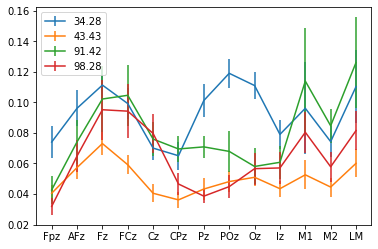

In [89]:
Freq_list = [34.28, 43.43, 91.42, 98.28]

x_names = ['Fpz','AFz','Fz','FCz','Cz','CPz','Pz','POz','Oz','Iz','M1','M2','LM']
out_m = df_group.mean()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()
out_s = df_group.std()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()/np.sqrt(len(ID_list))
for i in range(4):
    plt.errorbar(x_names,out_m[i,:],label=str(Freq_list[i]),yerr=out_s[i,:])
    
plt.legend()

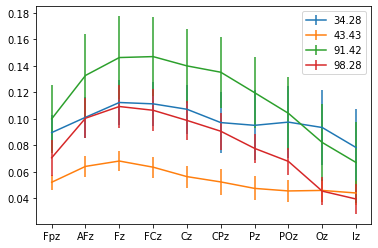

In [91]:
Freq_list = [34.28, 43.43, 91.42, 98.28]
x_names = ['Fpz','AFz','Fz','FCz','Cz','CPz','Pz','POz','Oz','Iz']

out_m = df_group.mean()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28']].to_numpy()
out_s = df_group.std()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28']].to_numpy()/np.sqrt(len(ID_list))
for i in range(4,8):
    plt.errorbar(x_names,out_m[i,:],label=str(Freq_list[i-4]),yerr=out_s[i,:])
    
plt.legend()

In [92]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [43.43, 233.13, 34.28, 217.13]

output = np.empty((len(ID_list)*2*len(Freq_list),71))
# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98), PLV*66 (64 channels+mastoid)


row_num = 0

for iSubject in ID_list:# range(2,18):

    folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/"
    sub_id = 'Sub' + str(iSubject) + '_HF'
    raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                   stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
    events = mne.find_events(raw)

    epochs = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
    epochs.load_data()
    ep_m = epochs.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])
    ep_a = epochs.copy().set_eeg_reference(ref_channels='average')

    data = ep_a.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_a = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_a = abs((xw_a/abs(xw_a)).mean(0))
    
    data = ep_m.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]   
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_m = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_m = abs((xw_m/abs(xw_m)).mean(0))
    
    freq = np.fft.rfftfreq(data.shape[2],1/4096)
    
    for iFreq in range(4):
        index = np.argmin(abs(freq-Freq_list[iFreq]))

        output[row_num,0] = iSubject
        output[row_num,1] = 0
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_a[0:66,index]
        output[row_num,69:71] = plv_a[67:69,index]
        
        row_num +=1
        
        output[row_num,0] = iSubject
        output[row_num,1] = 1
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_m[0:66,index]
        output[row_num,69:71] = plv_m[67:69,index]

        row_num +=1

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub7_HF/Sub7_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info stru

/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub8_HF/Sub8_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3452927  =      0.000 ...   843.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events foun

Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub21_HF/Sub21_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3244031  =      0.000 ...   792.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events fo

                                 ID        A1        A2        A3        A4  \
reference      frequency                                                      
average        34.28      14.214286  0.054854  0.045557  0.059323  0.076575   
               43.43      14.214286  0.034059  0.027874  0.039846  0.043659   
               217.13     14.214286  0.024767  0.033557  0.030959  0.045883   
               233.13     14.214286  0.037196  0.029934  0.038363  0.045907   
linked mastoid 34.28      14.214286  0.067037  0.056160  0.088648  0.104757   
               43.43      14.214286  0.046710  0.039659  0.042790  0.043226   
               217.13     14.214286  0.053385  0.049283  0.057774  0.069493   
               233.13     14.214286  0.050387  0.053539  0.067730  0.092894   

                                A5        A6        A7        A8        A9  \
reference      frequency                                                     
average        34.28      0.061751  0.043484  0.05217

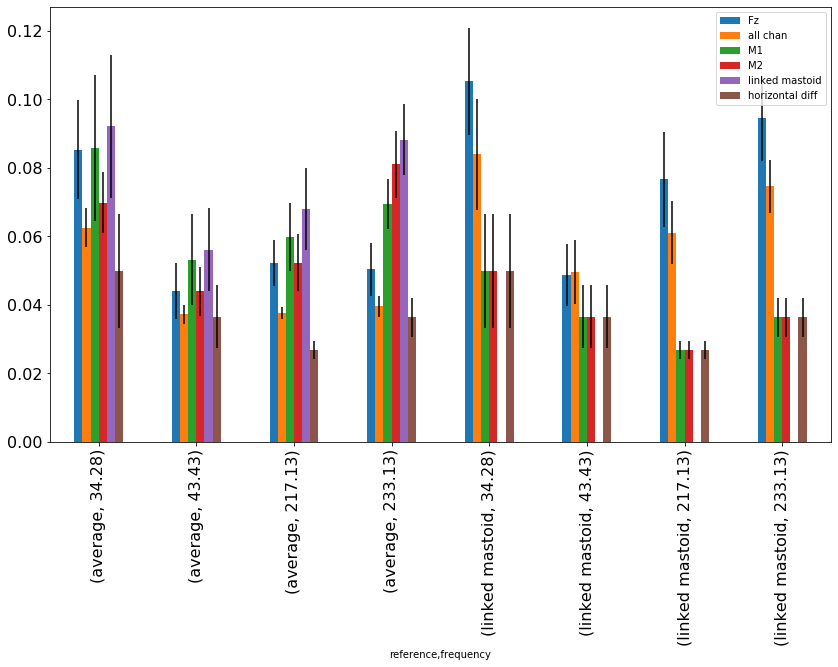

In [93]:
df = pd.DataFrame(output,columns=['ID','reference','frequency']
                  + epochs.info['ch_names'][0:66] + ['linked mastoid','horizontal diff'])
df.head()

dictionary = {0:'average',1:'linked mastoid'}

df_f = df.copy().replace({'reference':dictionary})

df_f['all chan'] = df_f.loc[:,'A1':'B32'].mean(axis=1)
df_f['Fz'] = df_f['B6']
df_f['M1'] = df_f['EXG1']
df_f['M2'] = df_f['EXG2']
df_group = df_f.groupby(by=['reference','frequency'])
df_avg = df_group.mean()
df_std = df_group.std()/np.sqrt(len(ID_list))
df_avg.drop(columns='ID')
print(df_avg)

p = df_avg[['Fz','all chan','M1','M2','linked mastoid','horizontal diff']].plot(kind='bar',yerr=df_std,figsize = (14,8),fontsize=16)


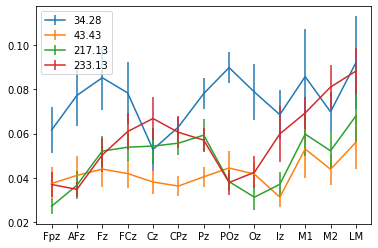

In [94]:
Freq_list = [34.28, 43.43, 217.13, 233.13]

x_names = ['Fpz','AFz','Fz','FCz','Cz','CPz','Pz','POz','Oz','Iz','M1','M2','LM']
out_m = df_group.mean()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()
out_s = df_group.std()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()/np.sqrt(len(ID_list))
for i in range(4):
    plt.errorbar(x_names,out_m[i,:],label=str(Freq_list[i]),yerr=out_s[i,:])
    
plt.legend()

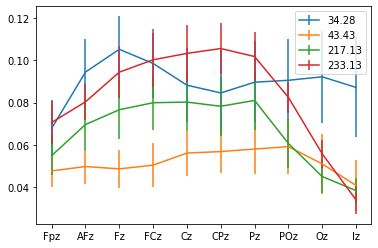

In [65]:
Freq_list = [34.28, 43.43, 217.13, 233.13]

x_names = ['Fpz','AFz','Fz','FCz','Cz','CPz','Pz','POz','Oz','Iz','LM']
out_m = df_group.mean()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','linked mastoid']].to_numpy()
out_s = df_group.std()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','linked mastoid']].to_numpy()/np.sqrt(len(ID_list))
for i in range(4,8):
    plt.errorbar(x_names,out_m[i,:],label=str(Freq_list[i-4]),yerr=out_s[i,:])
    
plt.legend()

In [76]:
ID_list = [6,7,8,9,10,12,13,14,16,17,18,19,20,21,22]
Freq_list = [43.43, 98.28,34.28, 91.42]

output = np.empty((len(ID_list)*2*len(Freq_list),71))
# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98), PLV*66 (64 channels+mastoid)


row_num=0

for iSubject in ID_list:# range(2,18):

    folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/"
    sub_id = 'Sub' + str(iSubject) + '_LF'
    raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR-10_MSK.bdf',
                                   stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
    events = mne.find_events(raw)

    epochs = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
    epochs.load_data()
    ep_m = epochs.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])
    ep_a = epochs.copy().set_eeg_reference(ref_channels='average')

    data = ep_a.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_a = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_a = abs((xw_a/abs(xw_a)).mean(0))

    data = ep_m.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]   
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_m = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_m = abs((xw_m/abs(xw_m)).mean(0))

    freq = np.fft.rfftfreq(data.shape[2],1/4096)

    for iFreq in range(len(Freq_list)):
        index = np.argmin(abs(freq-Freq_list[iFreq]))

        output[row_num,0] = iSubject
        output[row_num,1] = 0
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_a[0:66,index]
        output[row_num,69:71] = plv_a[67:69,index]

        row_num +=1

        output[row_num,0] = iSubject
        output[row_num,1] = 1
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_m[0:66,index]
        output[row_num,69:71] = plv_m[67:69,index]

        row_num +=1




Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1001 events found
Event IDs: [ 65409  65410 130944]
1001 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1001 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub7_LF/Sub7_LF_TMR-10_MSK.bdf...
BDF file detected
Setting chan

/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub8_LF/Sub8_LF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3293183  =      0.000 ...   804.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events fo

Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub20_LF/Sub20_LF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3276799  =      0.000 ...   800.000 secs...
Trigger channel has a non-zero initial value of 65408 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events f

                                 ID        A1        A2        A3        A4  \
reference      frequency                                                      
average        34.28      14.133333  0.055701  0.044455  0.067549  0.092880   
               43.43      14.133333  0.041168  0.027234  0.047778  0.054965   
               91.42      14.133333  0.040413  0.042204  0.063426  0.083560   
               98.28      14.133333  0.034198  0.037506  0.034722  0.048803   
linked mastoid 34.28      14.133333  0.089737  0.082982  0.092659  0.115634   
               43.43      14.133333  0.047043  0.037582  0.058473  0.055055   
               91.42      14.133333  0.099306  0.092578  0.132446  0.140012   
               98.28      14.133333  0.047177  0.045616  0.048422  0.066166   

                                A5        A6        A7        A8        A9  \
reference      frequency                                                     
average        34.28      0.079491  0.060773  0.05587

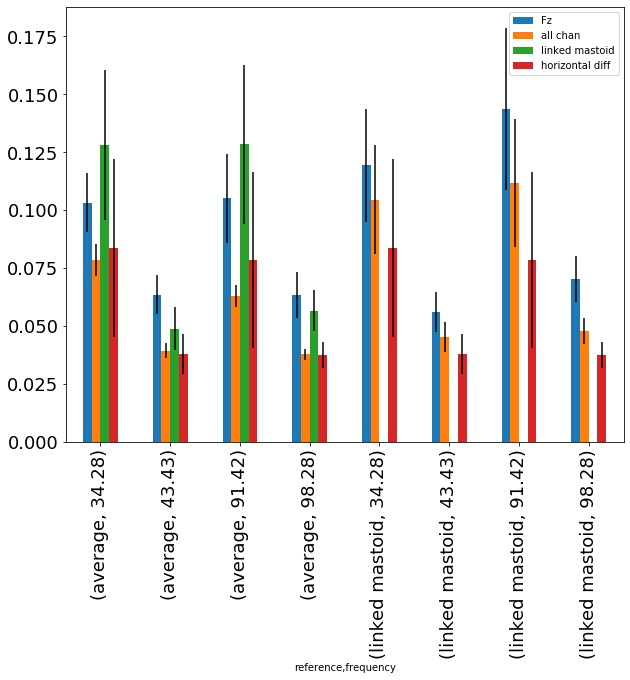

In [77]:

df = pd.DataFrame(output,columns=['ID','reference','frequency']
                  + epochs.info['ch_names'][0:66] + ['linked mastoid','horizontal diff'])
df.head()

dictionary = {0:'average',1:'linked mastoid'}

df_f = df.copy().replace({'reference':dictionary})

df_f['all chan'] = df_f.loc[:,'A1':'B32'].mean(axis=1)
df_f['Fz'] = df_f['B6']
df_group = df_f.groupby(by=['reference','frequency'])
df_avg = df_group.mean()
df_std = df_group.std()/np.sqrt(len(ID_list))
df_avg.drop(columns='ID')
print(df_avg)

p = df_avg[['Fz','all chan','linked mastoid','horizontal diff']].plot(kind='bar',yerr=df_std,figsize = (10,8),fontsize=18
                                                                     )

In [80]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [43.43, 233.13, 34.28, 217.13]

output = np.empty((len(ID_list)*2*len(Freq_list),71))
# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98), PLV*66 (64 channels+mastoid)


row_num = 0

for iSubject in ID_list:# range(2,18):

    folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/"
    sub_id = 'Sub' + str(iSubject) + '_HF'
    raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                   stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
    events = mne.find_events(raw)

    epochs = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
    epochs.load_data()
    ep_m = epochs.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])
    ep_a = epochs.copy().set_eeg_reference(ref_channels='average')

    data = ep_a.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_a = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_a = abs((xw_a/abs(xw_a)).mean(0))
    
    data = ep_m.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]   
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_m = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_m = abs((xw_m/abs(xw_m)).mean(0))
    
    freq = np.fft.rfftfreq(data.shape[2],1/4096)
    
    for iFreq in range(4):
        index = np.argmin(abs(freq-Freq_list[iFreq]))

        output[row_num,0] = iSubject
        output[row_num,1] = 0
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_a[0:66,index]
        output[row_num,69:71] = plv_a[67:69,index]
        
        row_num +=1
        
        output[row_num,0] = iSubject
        output[row_num,1] = 1
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_m[0:66,index]
        output[row_num,69:71] = plv_m[67:69,index]

        row_num +=1

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3358719  =      0.000 ...   820.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub7_HF/Sub7_HF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info 

/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Reading 0 ... 3280895  =      0.000 ...   801.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub8_HF/Sub8_HF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3428351  =      0.000 ...   837.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 eve

Creating raw.info structure...
Reading 0 ... 3366911  =      0.000 ...   822.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub21_HF/Sub21_HF_TMR-10_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3407871  =      0.000 ...   832.000 secs...
Trigger channel has a non-zero initial value of 65408 (consider using initial_event=Tru

                                 ID        A1        A2        A3        A4  \
reference      frequency                                                      
average        34.28      14.214286  0.051577  0.037344  0.063065  0.080318   
               43.43      14.214286  0.040800  0.035772  0.061290  0.067838   
               217.13     14.214286  0.033314  0.025409  0.031747  0.048867   
               233.13     14.214286  0.029493  0.028303  0.028234  0.035707   
linked mastoid 34.28      14.214286  0.062552  0.049737  0.079636  0.090523   
               43.43      14.214286  0.039145  0.033104  0.048961  0.060977   
               217.13     14.214286  0.061228  0.057903  0.065238  0.077104   
               233.13     14.214286  0.045278  0.045853  0.050406  0.068089   

                                A5        A6        A7        A8        A9  \
reference      frequency                                                     
average        34.28      0.062664  0.052925  0.04170

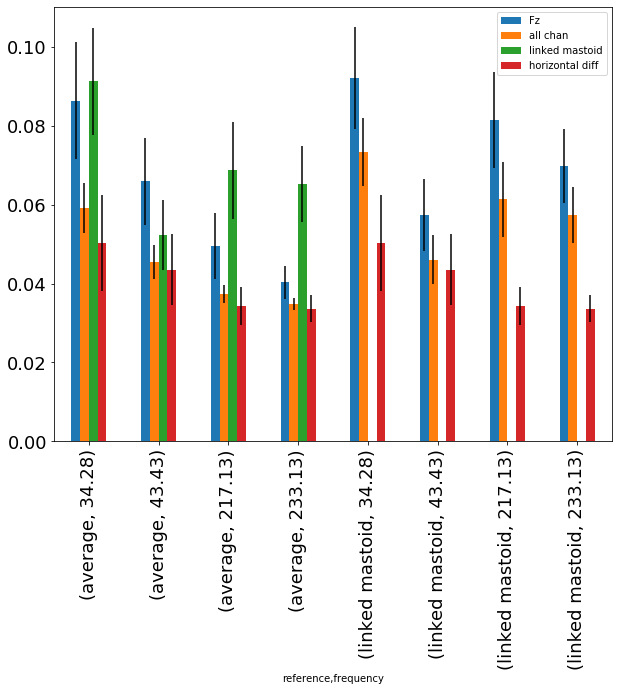

In [81]:

df = pd.DataFrame(output,columns=['ID','reference','frequency']
                  + epochs.info['ch_names'][0:66] + ['linked mastoid','horizontal diff'])
df.head()

dictionary = {0:'average',1:'linked mastoid'}

df_f = df.copy().replace({'reference':dictionary})

df_f['all chan'] = df_f.loc[:,'A1':'B32'].mean(axis=1)
df_f['Fz'] = df_f['B6']
df_group = df_f.groupby(by=['reference','frequency'])
df_avg = df_group.mean()
df_std = df_group.std()/np.sqrt(len(ID_list))
df_avg.drop(columns='ID')
print(df_avg)

p = df_avg[['Fz','all chan','linked mastoid','horizontal diff']].plot(kind='bar',yerr=df_std,figsize = (10,8),fontsize=18
                                                                     )

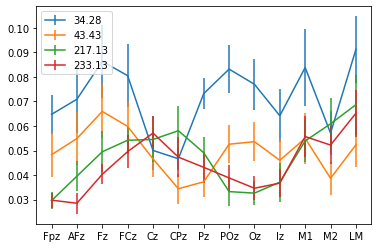

In [83]:
Freq_list = [34.28, 43.43, 217.13, 233.13]

x_names = ['Fpz','AFz','Fz','FCz','Cz','CPz','Pz','POz','Oz','Iz','M1','M2','LM']
out_m = df_group.mean()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()
out_s = df_group.std()[['B1','B5','B6','B15','B16','A32','A31','A30','A29','A28','EXG1','EXG2','linked mastoid']].to_numpy()/np.sqrt(len(ID_list))
for i in range(4):
    plt.errorbar(x_names,out_m[i,:],label=str(Freq_list[i]),yerr=out_s[i,:])
    
plt.legend()